In [116]:
#requisits and ignore warnings
import warnings
warnings.simplefilter('ignore')

import fnmatch
import collections
import keras
import librosa
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot, cm
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [117]:
df_train = pd.read_parquet("train.parquet")
df_test = pd.read_parquet("test.parquet")
set(df_test['number'])

{0, 1}

In [118]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(df_train.iloc[:, :-1], dtype = float)
y = df_train.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)


X_test = np.array(df_test.iloc[:, :-1], dtype = float)
y_test = df_test.iloc[:, -1]
print(set(y_train))

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)


{0, 1}
Y from training data: (9903,)
Y from validation data: (4245,)
Y from test data: (3586,)
X from training data (9903, 25)
X from validation data (4245, 25)
X from test data (3586, 25)


In [110]:
min_max_dict = {}
for column in df_train.columns:
    if column != 'id':
        min_max = {
            'min': df_train[column].min(),
            'max': df_train[column].max(),
        }
        min_max_dict[column] = min_max
print(min_max_dict)
def apply(df, min_max):
    for column in df.columns:
        if column != 'id':
            min_v = min_max[column]['min']
            max_v = min_max[column]['max']
            df[column] = (df[column] - min_v) / (max_v - min_v)

{'rmse': {'min': 0.0, 'max': 0.2987199425697326}, 'spectral_centroid': {'min': 0.0, 'max': 8700.11802616989}, 'spectral_bandwidth': {'min': 0.0, 'max': 4265.599155383625}, 'rolloff': {'min': 0.0, 'max': 10471.884800011005}, 'zero_crossing_rate': {'min': 0.0, 'max': 0.7746908698283451}, 'mfcc1': {'min': -1131.37109375, 'max': -80.93429565429688}, 'mfcc2': {'min': -26.236894607543945, 'max': 257.5633544921875}, 'mfcc3': {'min': -101.74254608154295, 'max': 67.23930358886719}, 'mfcc4': {'min': -41.43012619018555, 'max': 78.62216186523438}, 'mfcc5': {'min': -64.87045288085938, 'max': 58.97296142578125}, 'mfcc6': {'min': -71.82410430908203, 'max': 46.07552337646485}, 'mfcc7': {'min': -52.864013671875, 'max': 34.5647087097168}, 'mfcc8': {'min': -36.29061508178711, 'max': 24.04332733154297}, 'mfcc9': {'min': -51.674110412597656, 'max': 18.55243492126465}, 'mfcc10': {'min': -34.78253173828125, 'max': 26.022844314575195}, 'mfcc11': {'min': -37.08513259887695, 'max': 16.11619758605957}, 'mfcc12':

In [97]:
apply(df_train, min_max_dict)
apply(df_test, min_max_dict)

In [129]:
def extract_class_weights(labels):
    pos = sum(labels)
    total = len(labels)
    neg = total - pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    return {0: weight_for_0, 1: weight_for_1}

In [119]:
import os
import fnmatch
import collections
weight={}
total=0
path='audios/audios/56_speakers_audio_data'
for speaker in os.listdir(path):
    if speaker.find(".sh")==-1:
        dir_path=path+'/'+speaker
        speaker = int(speaker.split("_")[0].split("r")[1])
        if(speaker<=60 or speaker==62):
            speaker = 0
            total = total+int(len(fnmatch.filter(os.listdir(dir_path), '*.*'))*0.8)-1

        else:
            speaker= speaker-60
        count = int(len(fnmatch.filter(os.listdir(dir_path), '*.*'))*0.8)-1
        weight.update({speaker: count})
weight.update({0:total})
max_value=sum(weight.values())
print("Sum of values: "+str(max_value))
weight = {key: value for key, value in sorted(weight.items())}
print(weight)
class_weight = {k: 1-(v/max_value) for k, v in weight.items()}
print(class_weight)
#print(set(range(57)) - set(y_train))

Sum of values: 3272
{0: 3257, 1: 15}
{0: 0.004584352078239595, 1: 0.9954156479217604}


In [130]:
#X_train = np.array(df_train.drop('number', axis=1), dtype=np.float32)
#y_train = np.array(df_train.number == 1, dtype=np.uint32)
class_weight = extract_class_weights(y_train)
print(class_weight)
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(y_train), activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
#es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
print(X_train.shape)
#Train with early stopping to avoid overfitting
history = model.fit(X_train,y_train,validation_split=0.3,epochs=100,batch_size=128, class_weight=class_weight, callbacks=[es])

{0: 0.5005054078641463, 1: 495.15000000000003}
(9903, 25)
Epoch 1/100
55/55 [==============================] - 1s 11ms/step - loss: 7.9821 - accuracy: 0.8654 - val_loss: 6.2039 - val_accuracy: 0.9987
Epoch 2/100
55/55 [==============================] - 1s 10ms/step - loss: 5.1576 - accuracy: 0.9991 - val_loss: 0.3410 - val_accuracy: 0.9987
Epoch 3/100
55/55 [==============================] - 1s 10ms/step - loss: 3.5589 - accuracy: 0.9991 - val_loss: 0.0390 - val_accuracy: 0.9987
Epoch 4/100
55/55 [==============================] - 1s 10ms/step - loss: 2.9385 - accuracy: 0.9991 - val_loss: 0.0205 - val_accuracy: 0.9987
Epoch 5/100
55/55 [==============================] - 1s 9ms/step - loss: 2.4689 - accuracy: 0.9991 - val_loss: 0.0096 - val_accuracy: 0.9987
Epoch 6/100
55/55 [==============================] - 0s 9ms/step - loss: 2.2141 - accuracy: 0.9991 - val_loss: 0.0176 - val_accuracy: 0.9987
Epoch 7/100
55/55 [==============================] - 0s 9ms/step - loss: 1.2591 - accuracy: 

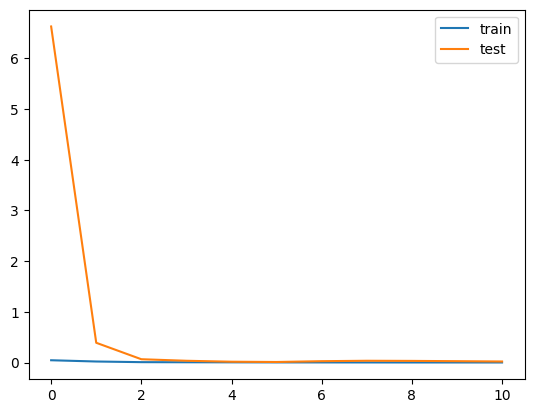

In [121]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [122]:
#X_test = np.array(df_test.drop('number', axis=1), dtype=np.float32)
#y_test = np.array(df_test.number == 1, dtype=np.uint32)

print('\n# TEST DATA #\n')
y_test=np.array(y_test, dtype=int)
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
# Prediction
#printPrediction(X_test, y_test, False, model)


# TEST DATA #



TypeError: in user code:

    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1668, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 700, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/silvia/anaconda3/lib/python3.9/site-packages/keras/metrics/metrics.py", line 3672, in sparse_categorical_accuracy
        if matches.shape.ndims > 1 and matches.shape[-1] == 1:

    TypeError: '>' not supported between instances of 'NoneType' and 'int'


In [123]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

def report(X_data, y_data):
    #Confution Matrix and Classification Report
    predict_y = model.predict(X_data)
    Y_pred = np.argmax(predict_y, axis=1)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt[len(set(y_test_num))-1])
    key=0
    for val in conf_mt[len(set(y_test_num))-1]:
        if val!=0:
            print(key)
        key=key+1
    conf_mt=conf_mt / conf_mt.astype(np.float).sum(axis=1)
    #print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, Y_pred))


Classification Report for Test Data

(3586,)
(3586, 25)
113/113 [==============================] - 0s 1ms/step
[24  0]
0


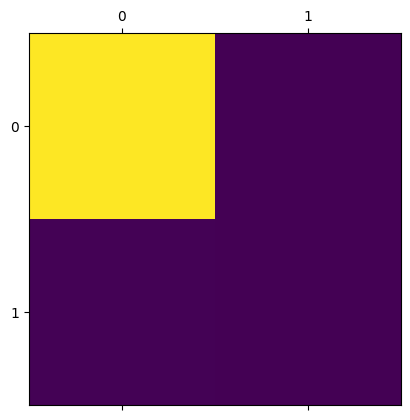


Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3562
           1       0.00      0.00      0.00        24

    accuracy                           0.99      3586
   macro avg       0.50      0.50      0.50      3586
weighted avg       0.99      0.99      0.99      3586



In [124]:
print("Classification Report for Test Data\n")
print(y_test.shape)
print(X_test.shape)
report(X_test, y_test)